### Implementation of Benson et al., 2016

In [1]:
import numpy as np 
import pandas as pd 
import scipy
from scipy import sparse as sp
from numpy import linalg as la
from scipy.sparse import csr_matrix as csr
from scipy.sparse import csgraph as csg
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.cluster import spectral_clustering
import networkx as netx
import warnings

warnings.filterwarnings("ignore")

In [2]:
# function definitions

def directional_matrices(A):
    """ returns bidirectional, unidirectional, and undirected versions of the graph described by A """
    
    # remove weights 
    nnz_inds = sp.find(A)
    A[nnz_inds[0], nnz_inds[1]] = 1
    
    # construct bidirectional matrix 
    B = csr.multiply(A, A.T).tocsr()
    B.data.fill(1)
    
    # construct the unidirectional matrix 
    U = A - B
    
    # construct the undirected matrix 
    G = csr.maximum(A, A.T)
    
    return B, U, G

def sp_not(A):
    """ elementwise not operator for sparse matrices """
    
    A = A.copy().tocsr()
    A.data.fill(1)
    
    return csr(np.ones(A.shape))-A
    

def bifan_adjacency(A):
    """ returns the motif adjacency matrix in the graph described by A """
    
    _, U, G = directional_matrices(A)
    
    NA = csr.multiply(sp_not(A), sp_not(A.T)).T     # adjacency matrix for the complement graph
    
    W = np.zeros(G.shape)
    
    ai, aj, _= sp.find(sp.triu(NA, 1))
    
    for (x, y) in zip(ai, aj):
        xout = sp.find(U[x, :])[1]
        yout = sp.find(U[y, :])[1]
        comm = np.intersect1d(xout, yout)
        num_common = len(comm)

        for i in range(num_common):
            for j in range(i+1, num_common):
                w = comm[i]
                v = comm[j]
                if NA[w, v] == 1:
                    W[x, y] += 1
                    W[x, w] += 1
                    W[x, v] += 1
                    W[y, w] += 1
                    W[y, v] += 1
                    W[w, v] += 1
    
    return csr(W + W.T).T

def M13_adjacency(A):
    
    B, _, G = directional_matrices(A)
    
    W = np.zeros(G.shape)
    N = G.shape[0]
    
    for i in range(N):
        J = sp.find(U[i, :])[1]
        for j1 in range(len(J)):
            for j2 in range(j1+1, len(J)):
                k1, k2 = J[j1], J[j2]
                if (A[k1, k2] == 0) and (A[k2, k1] == 0):
                    W[i, k1] = W[i, k1] + 1;
                    W[i, k2]  = W[i, k2] + 1;
                    W[k1, k2] = W[k1, k2] + 1;
    
    return csr(W + W.T).T

In [3]:
def spectral_parts(A):
    """ computes the spectral partition of adjacency matrix A and returns the indices of the smaller cluster """
    
    # compute the spectral ordering using the Fiedler vector 
    fiedler_vec = netx.fiedler_vector(netx.Graph(A), normalized=True, tol=1e-12)
    order = np.argsort(fiedler_vec)
    
    # compute the conductance values
    B = A[order][:, order]
    B_tril = sp.tril(B)
    B_sums = np.array(np.sum(B, -1))
    B_tril_sums = np.array(B_tril.sum(-1)).reshape(B_sums.shape)
    volumes = np.cumsum(B_sums)
    num_cut = np.cumsum(B_sums - 2 * B_tril_sums)
    total_vol = np.sum(A)
    volumes_other = total_vol * np.ones(len(order)) - volumes
    vols = np.minimum(volumes, volumes_other)
    conds = num_cut / vols
    conds = conds[:-1]
    
    # minimum conductance
    min_idx = np.argmin(conds)
    cond_min = conds[min_idx]
    
    # take the smaller cluster
    n = A.shape[0]
    if min_idx <= n // 2:
      cluster = order[0:min_idx]
    else:
      cluster = order[min_idx+1:]
    
    return cluster, cond_min, conds

def spectral_cut(M):
    
    graph = netx.Graph(M)
    
    # get the largest connected component
    lcc = np.array(list(max(netx.connected_components(graph), key=len)))
    lcc_mat = M[lcc][:, lcc]
    
    # compute the spectral partitions
    cluster, cond_min, conds = spectral_parts(lcc_mat)
    
    return lcc[cluster]

#### Read the data and construct motif adjacency matrix

In [9]:
# read the data 
data = scipy.io.loadmat(r"./mac95.mat")
mat_label = 'matrix'
pos_label = 'position'

In [10]:
A = csr(data[mat_label])         # connectivity matrix 
W = bifan_adjacency(A)           # motif adjacency matrix 

#### Looking at the conductance as a function of $S_r$

In [11]:
lcc = np.array(list(max(netx.connected_components(netx.Graph(W)), key=len)))
lcc_mat = W[lcc][:, lcc]

Text(0.5, 1.0, 'Motif conductances in terms of spectral ordering sets')

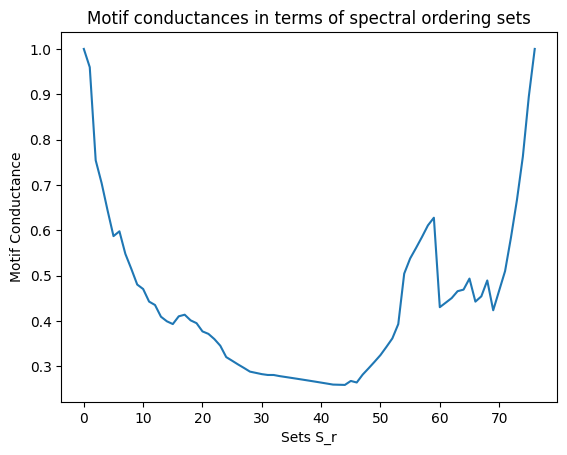

In [12]:
cluster, cond_min, conds = spectral_parts(lcc_mat)

plt.plot(conds)
plt.ylabel('Motif Conductance')
plt.xlabel('Sets S_r')
plt.title('Motif conductances in terms of spectral ordering sets')

#### Plotting the clusters

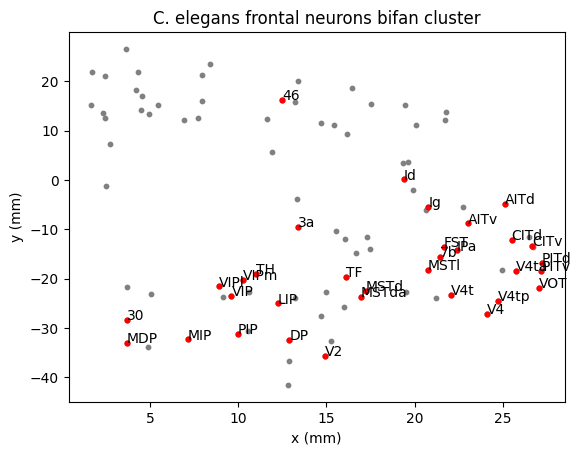

In [13]:
pos = data[pos_label]

plt.scatter(pos[:, 0], pos[:, 1], s=10, color='grey')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('C. elegans frontal neurons bifan cluster')


sc = spectral_cut(W)
plt.scatter(pos[sc, 0], pos[sc, 1], s=12, color='red')
labels = data['labels']
for ind in sc:
    plt.text(pos[ind, 0], pos[ind, 1], labels[ind, 0][0])